# Imports

In [106]:
import cv2
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
import os
from PIL import Image
from scipy.misc import imread
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data handling block

In [107]:
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

if GPU == True:
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    

#emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list for dataset48
emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
#emotions = ["fear", "happy"]

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("%s//%s//*" %(DATA_PATH,emotion))
    random.shuffle(files)
    training = files[:int(len(files)*0.6)] #get first 80% of file list
    prediction = files[-int(len(files)*0.4):] #get last 20% of file list
    return training, prediction

def make_sets():
    td = []
    tl = []
    pd = []
    pl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pd.append(item)
            pl.append(emotions.index(emotion))
        
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]
    
    data_p= {}
    for i in range(len(pd)):
        data_p[pd[i]] = pl[i]

    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)
    keys_p =  list(data_p.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_p)

    training_data = []
    training_labels = []
        #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        training_data.append(gray)
        training_labels.append(data_t[k])
    
    prediction_data = []
    prediction_labels = []
            #LOAD data
    for k in keys_p:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        prediction_data.append(gray)
        prediction_labels.append(data_p[k])
    return training_data, training_labels, prediction_data, prediction_labels


class data_loader(torch.utils.data.Dataset):
    def __init__(self, images_input,label_output):
        Images, Y = [], []
        
        for i in range(len(images_input)):
            Images.append(images_input[i])
            Y.append(label_output[i])

        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]      
        img = img.reshape(1, IMG_SIZE, IMG_SIZE) / 255
        
        #Input for Conv2D should be Channels x Height x Width
        img_tensor = transforms.ToTensor()(img).view(1, IMG_SIZE, IMG_SIZE).float()
        label = self.data[index][1]
        return (img_tensor, label)

Data path:  C:/Users/Cerberus/Documents/ML/Project/dataset299
Image size:  299
GPU enabled:  True
cuda:0


# Cross validation data handling

In [108]:
def make_one_set():
    td = []
    tl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            td.append(item)
            tl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]

        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)

    training_data = []
    training_labels = []
    #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        training_data.append(gray)
        training_labels.append(data_t[k])
    

    return training_data, training_labels



def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def chunks(l, n):
    """Return n-sized chunks from l."""
    chunks = list(get_chunks(l, n))

    #print(chunks)    
    if(len(chunks[-1]) < n):
        chunks[-2] = chunks[-2] + chunks[-1]
        del chunks[-1]

    return chunks

def get_separated_sets(sets,index):
    big_one = []
    small_one = []
    for i in range(len(sets)):
        if(i == index):
            small_one = sets[i]
        else:
            big_one = big_one + sets[i]
            
    return big_one,small_one

# Stats block

In [109]:
def get_accuracy(model,dataset):
    correct=0
    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
        
        pred=model.forward(test_x)
        y_hat=np.argmax(pred.data)
        if y_hat.item()==test_y.item():
            correct+=1
    return correct/len(dataset)


def get_stats(model,dataset):
    actu_all = []
    pred_all = []

    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
            
        pred=model.forward(test_x)
        y_hat=np.argmax(pred.data)
        
        if GPU == True:
            test_y = test_y.cpu()
            y_hat = y_hat.cpu()
        
        np_actu_y = test_y.data.numpy()[0]
        np_pred_y = y_hat.data.numpy().item()

        actu_all.append(np_actu_y)
        pred_all.append(np_pred_y)

    df_confusion = confusion_matrix(actu_all,pred_all)
    stats = classification_report(actu_all, pred_all)
    return df_confusion,stats

def get_label_quantity(label_set):
    myset = set(label_set)
    labels = np.zeros(len(myset))
    for i in range(len(label_set)):
        labels[label_set[i]] += 1 
    return labels

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# Data loading block

In [110]:
training_data, training_labels, prediction_data, prediction_labels = make_sets()

train_dataset = data_loader(training_data,training_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)


test_dataset = data_loader(prediction_data,prediction_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(training_data[0].shape)
print(prediction_labels)
print("training :",get_label_quantity(training_labels))
print("prediction :",get_label_quantity(prediction_labels))
print("Sum Training: ", np.sum(get_label_quantity(training_labels)))
print("Sum Testing: ", np.sum(get_label_quantity(prediction_labels)))

(299, 299)
[2, 1, 6, 3, 3, 2, 2, 0, 6, 4, 0, 6, 0, 4, 2, 2, 4, 6, 2, 5, 4, 2, 4, 1, 1, 0, 1, 5, 0, 6, 4, 2, 6, 2, 6, 4, 3, 4, 6, 3, 6, 6, 6, 0, 2, 6, 4, 2, 4, 4, 4, 6, 6, 4, 5, 6, 6, 3, 4, 3, 6, 6, 2, 0, 6, 6, 0, 0, 2, 0, 4, 6, 0, 2, 2, 0, 4, 4, 2, 5, 6, 1, 0, 4, 0, 4, 4, 2, 5, 4, 5, 6, 4, 6, 2, 6, 0, 5, 4, 2, 3, 4, 6, 1, 2, 5, 0, 5, 6, 6, 6, 6, 3, 6, 3, 5, 5, 2, 6, 4, 4, 4, 2, 3, 1, 0, 2, 0]
training : [27. 10. 35. 15. 41. 16. 48.]
prediction : [18.  7. 23. 10. 27. 11. 32.]
Sum Training:  192.0
Sum Testing:  128.0


# Model and training definition

In [125]:
#MODEL
#
OUTPUT_CONV = 27

#img -> 48*48
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,12)
        self.maxpool2d = nn.MaxPool2d(5,5,2)
        self.fc1 = nn.Linear(10*OUTPUT_CONV*OUTPUT_CONV, 20)
        self.fc2 = nn.Linear(20, 7)

    def forward(self, x):
        #print("x ", x.shape)
        x = self.conv1(x)
        #print("conv1 ", x.shape)
        x = self.avgpool2d(x)
        #print("avgpool2d ", x.shape)
        x = self.conv2(x)
        #print("conv2 ", x.shape)
        x = self.maxpool2d(x)
        #print("maxpool2d ", x.shape)
        x = x.view(-1, 10*OUTPUT_CONV*OUTPUT_CONV)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        #result = F.softmax(x, dim=1)
        return result

def trainClassifier(net,train_set,test_set,criterion,optimizer,epochs,volubile=False,security=False):
    history = []
    sec_limit = 6
    counter_sec = 0
    for epoch in range(1, epochs+1):
        if volubile == True:  
            print('Epoch {}/{}'.format(epoch, epochs))
            print('-' * 10)
        
        for step, data in enumerate(train_set, 0):
            train_x, train_y = data
            if GPU == True:
                train_x, train_y = train_x.cuda(), train_y.cuda()
            else:
                train_y = torch.LongTensor(np.array(train_y))
                
            y_hat = net.forward(train_x)
            
            loss = criterion(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if security == True:
            if len(history) > 0:
                if loss.item() == history[-1]:
                    counter_sec += 1
                
        if counter_sec >= sec_limit:
            print('*'*35)
            print("NO TRAINING: ",sec_limit," times the same loss")
            print('*'*35)
            break
            
        history.append(loss.item())
        if volubile == True:  
            epoch_training_acc = get_accuracy(net,train_set)
            print('{} -> Acc: {:.4f}'.format("training",epoch_training_acc))
            epoch_testing_acc = get_accuracy(net,test_set)
            print('{} -> Acc: {:.4f}'.format("testing", epoch_testing_acc))
     
    return net, history

def cross_validation_score_299(data,labels,epochs,cv=5):
    chunk_size = int(len(set_data_cv)/cv)
    #divide the sets by cv
    data_sets = list(chunks(set_data_cv,chunk_size))
    label_sets = list(chunks(set_labels_cv,chunk_size))
    
    OUTPUT_CONV = 27
    
    nets = []
    histories = []
    accuracies = []
    confmats = []

    for i in range(cv):
        print("------------------------------- ",i,"/",cv)

        
        #foreach cv_sets create training and testing
        training_data, prediction_data  = get_separated_sets(data_sets,i)
        training_labels, prediction_labels = get_separated_sets(label_sets,i)
        print("training :",get_label_quantity(training_labels))
        print("prediction :",get_label_quantity(prediction_labels))
        
        train_dataset = data_loader(training_data,training_labels)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
        test_dataset = data_loader(prediction_data,prediction_labels)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        #and train
        #reset all model
        net = Model()
        if GPU == True:
            net.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(net.parameters())
        optimizer =torch.optim.Adam(net.parameters(), 0.1, (0.9, 0.999), 0.1, 5e-05)
        #optimizer = torch.optim.Adadelta(net.parameters(), 1.0, 0.9, 1e-06, 5e-05)
        c_net,c_hist = trainClassifier(net,train_loader,test_loader,criterion,optimizer,epochs)

        nets.append(c_net)
        histories.append(c_hist)
        
        #and get accuracy
        c_acc = get_accuracy(c_net,test_loader)
        c_confmat = get_stats(c_net,test_loader)
        
        print("Accuracy: %0.2f" % (c_acc))
        
        accuracies.append(c_acc)
        confmats.append(c_confmat)
        
    return nets, histories, accuracies, confmats

# Training (299x299)

In [112]:
N_EPOCHS=100

net = Model()
if GPU == True:
    net.cuda()
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.Adam(net.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer = torch.optim.Adagrad(net.parameters(), 1.0, 0, 0.1,0)
#optimizer = torch.optim.ASGD(net.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
#optimizer = torch.optim.Adadelta(net.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(net.parameters(),lr=1e-3, momentum=0.9, dampening=0)

classifier, loss_history = trainClassifier(net,train_loader,test_loader,criterion,optimizer,N_EPOCHS,True)

Epoch 1/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 2/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 3/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 4/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 5/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 6/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 7/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 8/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 9/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 10/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 11/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 12/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 13/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 14/100
----------
training -> Acc: 0.1406
testing -> Acc: 0.1406
Epoch 15/100
--

# Result display (299x299)

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger       18        0        0        0        0        0        0 
    contempt        7        0        0        0        0        0        0 
     disgust       23        0        0        0        0        0        0 
        fear       10        0        0        0        0        0        0 
       happy       27        0        0        0        0        0        0 
     sadness       11        0        0        0        0        0        0 
    surprise       32        0        0        0        0        0        0 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.14      1.00      0.25        18
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        27
           

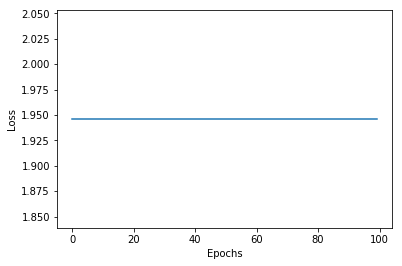

In [118]:
IMG_SIZE = 299
acc = get_accuracy(classifier,test_loader)
confmat,stats = get_stats(classifier,test_loader)

print_cm(confmat,emotions)
print("-----------------------------------------------")
print(stats)
print("Accuracy (299x299) : %0.2f" % (acc))
plt.plot(np.array(range(len(loss_history))), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Cross validation (299x299)

In [120]:
#Reloead data
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

training_data, training_labels, prediction_data, prediction_labels = make_sets()

train_dataset = data_loader(training_data,training_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)


test_dataset = data_loader(prediction_data,prediction_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(training_data[0].shape)
print(prediction_labels)
print("training :",get_label_quantity(training_labels))
print("prediction :",get_label_quantity(prediction_labels))
print("Sum Training: ", np.sum(get_label_quantity(training_labels)))
print("Sum Testing: ", np.sum(get_label_quantity(prediction_labels)))

set_data_cv, set_labels_cv = make_one_set()
print(len(set_labels_cv))

cv = 5
chunk_size = int(len(set_data_cv)/cv)
#divide the sets by cv
data_sets = list(chunks(set_data_cv,chunk_size))
label_sets = list(chunks(set_labels_cv,chunk_size))

print(training_data[0].shape)
for i in range(cv):
    #foreach cv_sets create training and testing
    training_data, prediction_data  = get_separated_sets(data_sets,i)
    training_labels, prediction_labels = get_separated_sets(label_sets,i)
    #print("---------------------------------------------")
    #print("training :",get_label_quantity(training_labels))
    #print("prediction :",get_label_quantity(prediction_labels))
    
N_EPOCHS = 50
nets,histories, accuracies, confmats = cross_validation_score_299(set_data_cv,set_labels_cv,N_EPOCHS)

acc_mean = np.mean(accuracies, axis=0)
acc_dev = np.std(accuracies, axis=0)
print("=========================================")
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_mean, acc_dev * 2))

(299, 299)
[5, 4, 1, 5, 2, 1, 3, 4, 0, 6, 6, 2, 0, 1, 6, 4, 0, 5, 2, 6, 6, 6, 6, 6, 6, 6, 3, 0, 4, 6, 4, 6, 3, 2, 2, 6, 5, 5, 6, 4, 4, 0, 0, 3, 0, 3, 6, 2, 0, 4, 0, 6, 6, 1, 2, 5, 2, 5, 4, 0, 4, 4, 4, 0, 6, 4, 4, 4, 2, 6, 6, 2, 0, 4, 3, 6, 5, 2, 4, 3, 2, 6, 1, 4, 2, 0, 4, 0, 4, 4, 4, 6, 3, 2, 6, 6, 6, 0, 6, 1, 4, 2, 1, 2, 6, 0, 2, 3, 2, 0, 6, 2, 4, 5, 5, 2, 6, 4, 4, 4, 2, 5, 2, 3, 0, 2, 6, 6]
training : [27. 10. 35. 15. 41. 16. 48.]
prediction : [18.  7. 23. 10. 27. 11. 32.]
Sum Training:  192.0
Sum Testing:  128.0
320
(299, 299)
---------------------------------------------
training : [35. 16. 45. 19. 57. 22. 62.]
prediction : [10.  1. 13.  6. 11.  5. 18.]
---------------------------------------------
training : [35. 14. 51. 21. 55. 18. 62.]
prediction : [10.  3.  7.  4. 13.  9. 18.]
---------------------------------------------
training : [36. 14. 43. 20. 53. 24. 66.]
prediction : [ 9.  3. 15.  5. 15.  3. 14.]
---------------------------------------------
training : [37. 13. 42. 21. 

# CNN (48x48)

In [129]:
OUTPUT_CONV = 2

#img -> 48*48
class Model_48(torch.nn.Module):

    def __init__(self):
        super(Model_48, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,12)
        self.maxpool2d = nn.MaxPool2d(5,5,2)
        self.fc1 = nn.Linear(10*OUTPUT_CONV*OUTPUT_CONV, 20)
        self.fc2 = nn.Linear(20, 7)

    def forward(self, x):
        #print("x ", x.shape)
        x = self.conv1(x)
        #print("conv1 ", x.shape)
        x = self.avgpool2d(x)
        #print("avgpool2d ", x.shape)
        x = self.conv2(x)
        #print("conv2 ", x.shape)
        x = self.maxpool2d(x)
        #print("maxpool2d ", x.shape)
        x = x.view(-1, 10*OUTPUT_CONV*OUTPUT_CONV)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        #result = F.softmax(x, dim=1)
        return result
    
def cross_validation_score_48(data,labels,epochs,cv=5):
    chunk_size = int(len(set_data_cv)/cv)
    #divide the sets by cv
    data_sets = list(chunks(set_data_cv,chunk_size))
    label_sets = list(chunks(set_labels_cv,chunk_size))
    
    nets = []
    histories = []
    accuracies = []
    confmats = []

    for i in range(cv):
        print("------------------------------- ",i,"/",cv)

        
        #foreach cv_sets create training and testing
        training_data, prediction_data  = get_separated_sets(data_sets,i)
        training_labels, prediction_labels = get_separated_sets(label_sets,i)
        print("training :",get_label_quantity(training_labels))
        print("prediction :",get_label_quantity(prediction_labels))
        
        train_dataset = data_loader(training_data,training_labels)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
        test_dataset = data_loader(prediction_data,prediction_labels)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        #and train
        #reset all model
        net = Model_48()
        if GPU == True:
            net.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters())
        #optimizer =torch.optim.Adam(net.parameters(), 0.1, (0.9, 0.999), 0.1, 5e-05)
        #optimizer = torch.optim.Adadelta(net.parameters(), 1.0, 0.9, 1e-06, 5e-05)
        c_net,c_hist = trainClassifier(net,train_loader,test_loader,criterion,optimizer,epochs)

        nets.append(c_net)
        histories.append(c_hist)
        
        #and get accuracy
        c_acc = get_accuracy(c_net,test_loader)
        c_confmat = get_stats(c_net,test_loader)
        
        print("Accuracy: %0.2f" % (c_acc))
        
        accuracies.append(c_acc)
        confmats.append(c_confmat)
        
    return nets, histories, accuracies, confmats

# Data loading (48x48)

In [130]:
IMG_SIZE = 48
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset48"

print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

training_data, training_labels, prediction_data, prediction_labels = make_sets()

train_dataset = data_loader(training_data,training_labels)
train_loader48 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)


test_dataset = data_loader(prediction_data,prediction_labels)
test_loader48 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


print(prediction_labels)
print("training :",get_label_quantity(training_labels))
print("prediction :",get_label_quantity(prediction_labels))
print("Sum Training: ", np.sum(get_label_quantity(training_labels)))
print("Sum Testing: ", np.sum(get_label_quantity(prediction_labels)))

Data path:  C:/Users/Cerberus/Documents/ML/Project/dataset48
Image size:  48
GPU enabled:  True
[1, 3, 2, 4, 0, 4, 5, 4, 4, 6, 0, 0, 0, 5, 4, 6, 3, 1, 3, 2, 5, 4, 2, 0, 4, 6, 3, 2, 4, 6, 2, 2, 6, 6, 6, 4, 2, 6, 0, 6, 4, 4, 6, 6, 4, 0, 4, 0, 6, 0, 2, 5, 3, 2, 0, 6, 6, 6, 1, 4, 2, 0, 6, 4, 3, 2, 0, 1, 4, 3, 0, 0, 5, 4, 2, 0, 6, 5, 4, 3, 2, 6, 6, 4, 2, 6, 4, 2, 6, 5, 6, 6, 6, 4, 4, 4, 6, 6, 2, 5, 2, 1, 2, 2, 6, 6, 2, 4, 2, 5, 6, 1, 0, 1, 6, 5, 5, 2, 6, 3, 6, 6, 3, 0, 2, 4, 4, 4, 0]
training : [27. 10. 35. 15. 41. 16. 49.]
prediction : [18.  7. 23. 10. 27. 11. 33.]
Sum Training:  193.0
Sum Testing:  129.0


# Training (48x48)

In [124]:
N_EPOCHS=100

net48 = Model_48()
if GPU == True:
    net48.cuda()
    
criterion48 = torch.nn.CrossEntropyLoss()
optimizer48 = torch.optim.Adam(net48.parameters())
#optimizer48 = torch.optim.Adam(net48.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer48 = torch.optim.Adagrad(net48.parameters(), 1.0, 0, 0.1,0)
#optimizer48 = torch.optim.ASGD(net48.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
#optimizer48 = torch.optim.Adadelta(net48.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer48 = torch.optim.SGD(net48.parameters(),lr=1e-3, momentum=0.9, dampening=0)

classifier48, loss_history48 = trainClassifier(net48,train_loader48,test_loader48,criterion48,optimizer48,N_EPOCHS,True,True)

Epoch 1/100
----------
training -> Acc: 0.2591
testing -> Acc: 0.2558
Epoch 2/100
----------
training -> Acc: 0.5492
testing -> Acc: 0.5194
Epoch 3/100
----------
training -> Acc: 0.5959
testing -> Acc: 0.5581
Epoch 4/100
----------
training -> Acc: 0.7150
testing -> Acc: 0.6899
Epoch 5/100
----------
training -> Acc: 0.7254
testing -> Acc: 0.6279
Epoch 6/100
----------
training -> Acc: 0.7098
testing -> Acc: 0.6667
Epoch 7/100
----------
training -> Acc: 0.6943
testing -> Acc: 0.6744
Epoch 8/100
----------
training -> Acc: 0.7565
testing -> Acc: 0.6589
Epoch 9/100
----------
training -> Acc: 0.6943
testing -> Acc: 0.5814
Epoch 10/100
----------
training -> Acc: 0.7720
testing -> Acc: 0.6899
Epoch 11/100
----------
training -> Acc: 0.7772
testing -> Acc: 0.6899
Epoch 12/100
----------
training -> Acc: 0.7824
testing -> Acc: 0.7054
Epoch 13/100
----------
training -> Acc: 0.6632
testing -> Acc: 0.5736
Epoch 14/100
----------
training -> Acc: 0.7824
testing -> Acc: 0.7054
Epoch 15/100
--

# Result display(48x48)

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger       18        0        0        0        0        0        0 
    contempt        6        0        0        1        0        0        0 
     disgust        2        0       21        0        0        0        0 
        fear        3        0        0        7        0        0        0 
       happy        2        0        0        0       25        0        0 
     sadness       10        0        0        0        0        0        1 
    surprise        2        0        0        0        0        0       31 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        18
           1       0.00      0.00      0.00         7
           2       1.00      0.91      0.95        23
           3       0.88      0.70      0.78        10
           4       1.00      0.93      0.96        27
           

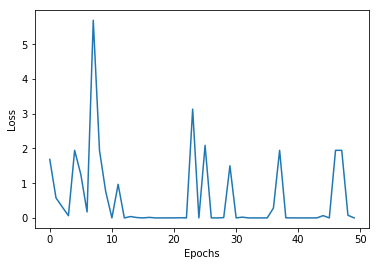

In [131]:
IMG_SIZE = 48
OUTPUT_CONV = 2


acc48 = get_accuracy(classifier48,test_loader48)
confmat48,stats48 = get_stats(classifier48,test_loader48)

print_cm(confmat48,emotions)
print("-----------------------------------------------")
print(stats48)
print("Accuracy (48x48) : %0.2f" % (acc48))
plt.plot(np.array(range(len(loss_history48))), loss_history48)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Cross validation (48x48)

In [133]:
set_data_cv, set_labels_cv = make_one_set()
print(len(set_labels_cv))

cv = 5
chunk_size = int(len(set_data_cv)/cv)
#divide the sets by cv
data_sets = list(chunks(set_data_cv,chunk_size))
label_sets = list(chunks(set_labels_cv,chunk_size))

print(training_data[0].shape)
for i in range(cv):
    #foreach cv_sets create training and testing
    training_data, prediction_data  = get_separated_sets(data_sets,i)
    training_labels, prediction_labels = get_separated_sets(label_sets,i)
    #print("---------------------------------------------")
    #print("training :",get_label_quantity(training_labels))
    #print("prediction :",get_label_quantity(prediction_labels))
    
N_EPOCHS = 50
nets,histories, accuracies, confmats = cross_validation_score_48(set_data_cv,set_labels_cv,N_EPOCHS)

acc_mean = np.mean(accuracies, axis=0)
acc_dev = np.std(accuracies, axis=0)
print("=========================================")
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_mean, acc_dev * 2))

322
(48, 48)
-------------------------------  0 / 5
training : [34. 10. 48. 21. 51. 25. 69.]
prediction : [11.  7. 10.  4. 17.  2. 13.]
Accuracy: 0.73
-------------------------------  1 / 5
training : [39. 14. 48. 20. 57. 22. 58.]
prediction : [ 6.  3. 10.  5. 11.  5. 24.]
Accuracy: 0.73
-------------------------------  2 / 5
training : [34. 16. 45. 20. 51. 22. 70.]
prediction : [11.  1. 13.  5. 17.  5. 12.]
Accuracy: 0.17
-------------------------------  3 / 5
training : [37. 13. 42. 23. 56. 20. 67.]
prediction : [ 8.  4. 16.  2. 12.  7. 15.]
Accuracy: 0.72
-------------------------------  4 / 5
training : [36. 15. 49. 16. 57. 19. 64.]
prediction : [ 9.  2.  9.  9. 11.  8. 18.]
Accuracy: 0.14
Accuracy: 0.50 (+/- 0.56)
